# Wages model

import warnings
warnings.filterwarnings("error")

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pymc.sampling.jax as pmjax
import jax
import re
from io import StringIO 
import sys
import datetime

# Configurations
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# Set random seed
RANDOM_SEED = 230810
rng = np.random.default_rng(RANDOM_SEED)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Run this cell to set up ["CPU"] as the default backend for JAX. NOTE: Any change to the backend requires a restart of the kernel.
# CPU seems to be faster than GPU for this model
jax.config.update('jax_platform_name', 'cpu')
print(f"JAX default backend: {jax.default_backend()}")

JAX default backend: cpu


## a. Aux Functions

In [3]:
# Create a context manager that captures stdout output (Numpyro prints to stdout)
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

In [4]:
def sampling_output(sampling_info, nchains, ndraws, ntunes):
    """ Function to organize the sampling info after the NUTS sampler has run."""
    sampling_metadata = {}
    for location, stage in enumerate(["Compilation", "Sampling", "Transformation"]):
        stage_duration = re.search(fr'{stage} time =\s+(\d+:\d+:\d+\.\d+)', sampling_info[(location * 2) + 1]).group(1)
        sampling_metadata[f"{stage}_time"] = stage_duration
        if stage == "Sampling":
            sampling_time_seconds = pd.to_timedelta(stage_duration).total_seconds()
            sampling_metadata["AvgIt/s"] = round(((ndraws + ntunes) * nchains) / sampling_time_seconds, 2)

    return sampling_metadata

## 1. Prepare Data

In [10]:
# Import data
data = pd.read_csv("../model_dataset.csv")

In [11]:
# # Filter out columns of interest
# df = data[["industry","occup","ftpt","sex","self_emp","union","public_sector","multiple_jobs","salary"]]

# # Convert to categorical
# df = df.rename(columns={"industry":"ind", "occup": "occ"})
# df["ptm"] = pd.factorize(df["ftpt"])[0]
# df["gender"] = pd.factorize(df["sex"])[0]
# df["self"] = pd.factorize(df["self_emp"])[0]
# df["union"] = pd.factorize(df["union"])[0]
# df["public_sector"] = pd.factorize(df["public_sector"])[0]
# df["multiple_jobs"] = pd.factorize(df["multiple_jobs"])[0]

# # Drop columns
# df = df.drop(columns=["ftpt","sex","self_emp"])
# df.head(3)

In [12]:
# Dataset description
data.describe()

Unnamed: 0     edu_level  elementary_edu  highschool_edu  \
count   87057.000000  87057.000000    87057.000000    87057.000000   
mean   120518.594725      3.675098        0.980622        0.875840   
std     69758.201763      1.122183        0.137851        0.329766   
min         2.000000      0.000000        0.000000        0.000000   
25%     60227.000000      3.000000        1.000000        1.000000   
50%    120467.000000      4.000000        1.000000        1.000000   
75%    181210.000000      4.000000        1.000000        1.000000   
max    241331.000000      6.000000        1.000000        1.000000   

        postsec_edu  undergrad_edu  graduate_edu  grad_highschool_refyear  \
count  87057.000000   87057.000000  87057.000000             87057.000000   
mean       0.379556       0.199662      0.055332                 0.006134   
std        0.485279       0.399749      0.228628                 0.078079   
min        0.000000       0.000000      0.000000                 0.000000   
25%        0.000000       0.000000      0.000000                 0.000000   
50%        0.000000       0.000000      0.000000                 0.000000   
75%        1.000000       0.000000      0.000000                 0.000000   
max        1.000000       1.000000      1.000000                 1.000000   

       grad_college_refyear  grad_univ_refyear  ...    hours_paid  \
count          87057.000000       87057.000000  ...  87053.000000   
mean               0.023697           0.012704  ...   1835.978094   
std                0.152105           0.111996  ...    528.398371   
min                0.000000           0.000000  ...      0.000000   
25%                0.000000           0.000000  ...   1667.000000   
50%                0.000000           0.000000  ...   1955.000000   
75%                0.000000           0.000000  ...   2086.000000   
max                1.000000           1.000000  ...   9997.000000   

       months_last_worked        tenure           sex           age  \
count         2576.000000  87057.000000  87057.000000  87057.000000   
mean             3.270575    113.547595      0.474953     40.352034   
std              2.897901    108.744224      0.499375     11.347999   
min              0.000000      0.000000      0.000000     16.000000   
25%              1.000000     26.000000      0.000000     31.000000   
50%              2.000000     75.000000      0.000000     41.000000   
75%              5.000000    173.000000      1.000000     49.000000   
max             12.000000    634.000000      1.000000     69.000000   

               year        weight        salary     firm_size      loc_size  
count  87057.000000  87057.000000  8.705700e+04  87057.000000  87057.000000  
mean    2003.095282    580.021940  6.805309e+04    478.752633    169.524587  
std        4.680218    574.759705  4.696846e+04    461.927153    310.957627  
min     1996.000000      9.091900  3.242512e+01      1.000000      1.000000  
25%     1999.000000    218.074200  3.761314e+04     20.000000      1.000000  
50%     2003.000000    391.174400  6.015434e+04    100.000000     20.000000  
75%     2007.000000    734.123100  8.900095e+04   1000.000000    100.000000  
max     2011.000000  14222.813500  1.593453e+06   1000.000000   1000.000000  

[8 rows x 29 columns]

In [15]:
data.reindex().query("year == 1997").to_csv("1997_dataset.csv")

In [14]:
df = pd.read_csv("1997_dataset.csv")

FileNotFoundError: [Errno 2] No such file or directory: '1997_dataset.csv'

## 2. Model

In [10]:
ind_idx, industries = pd.factorize(df["industry"])
sex_idx, sex = pd.factorize(df["sex"])
salaries = df["salary"].values

# Create coords
coords = {
    "obs": df.index,
    "ind": industries,
    "sex": sex
}

In [39]:
with pm.Model(coords=coords) as baseModel:
    # Data
    ind = pm.MutableData("ind", ind_idx)
    gender = pm.MutableData("gen", sex_idx)

    # Hyperpriors
    mu_intercept = pm.Normal("mu_int", mu=0, sigma=10)
    sigma_intercept = pm.HalfNormal("sigma_int", sigma=10)
    mu_gender = pm.Normal("mu_gen", mu=0, sigma=10)
    sigma_gender = pm.HalfNormal("sigma_gen", sigma=10)

    # Priors
    offset_int = pm.Normal("offset_int", mu=0, sigma=1)
    intercept = pm.Deterministic("intercept", mu_intercept + offset_int * sigma_intercept)
    offset_gen = pm.Normal("offset_gen", mu=0, sigma=1)
    beta_gen = pm.Deterministic("beta_gen", mu_gender + offset_gen * sigma_gender)

    # Expected value
    ev = pm.Deterministic('ev', intercept + beta_gen * gender)
    mu = pm.Deterministic('mu',pm.math.exp(ev))

    # Model error
    shape = pm.Exponential("shape", lam=1)

    # Likelihood
    salary = pm.Gamma("salary", alpha=shape, beta=shape/mu, observed=salaries)   

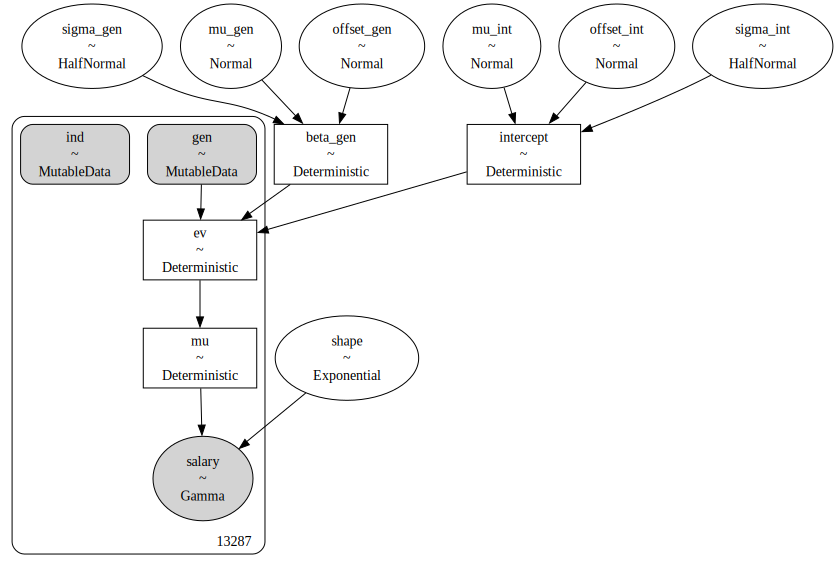

In [40]:
pm.model_to_graphviz(baseModel)

In [41]:
with baseModel:
    trace_fulldataset = pmjax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:02.172185
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:08:02.179639
Transforming variables...
Transformation time =  0:00:01.087301


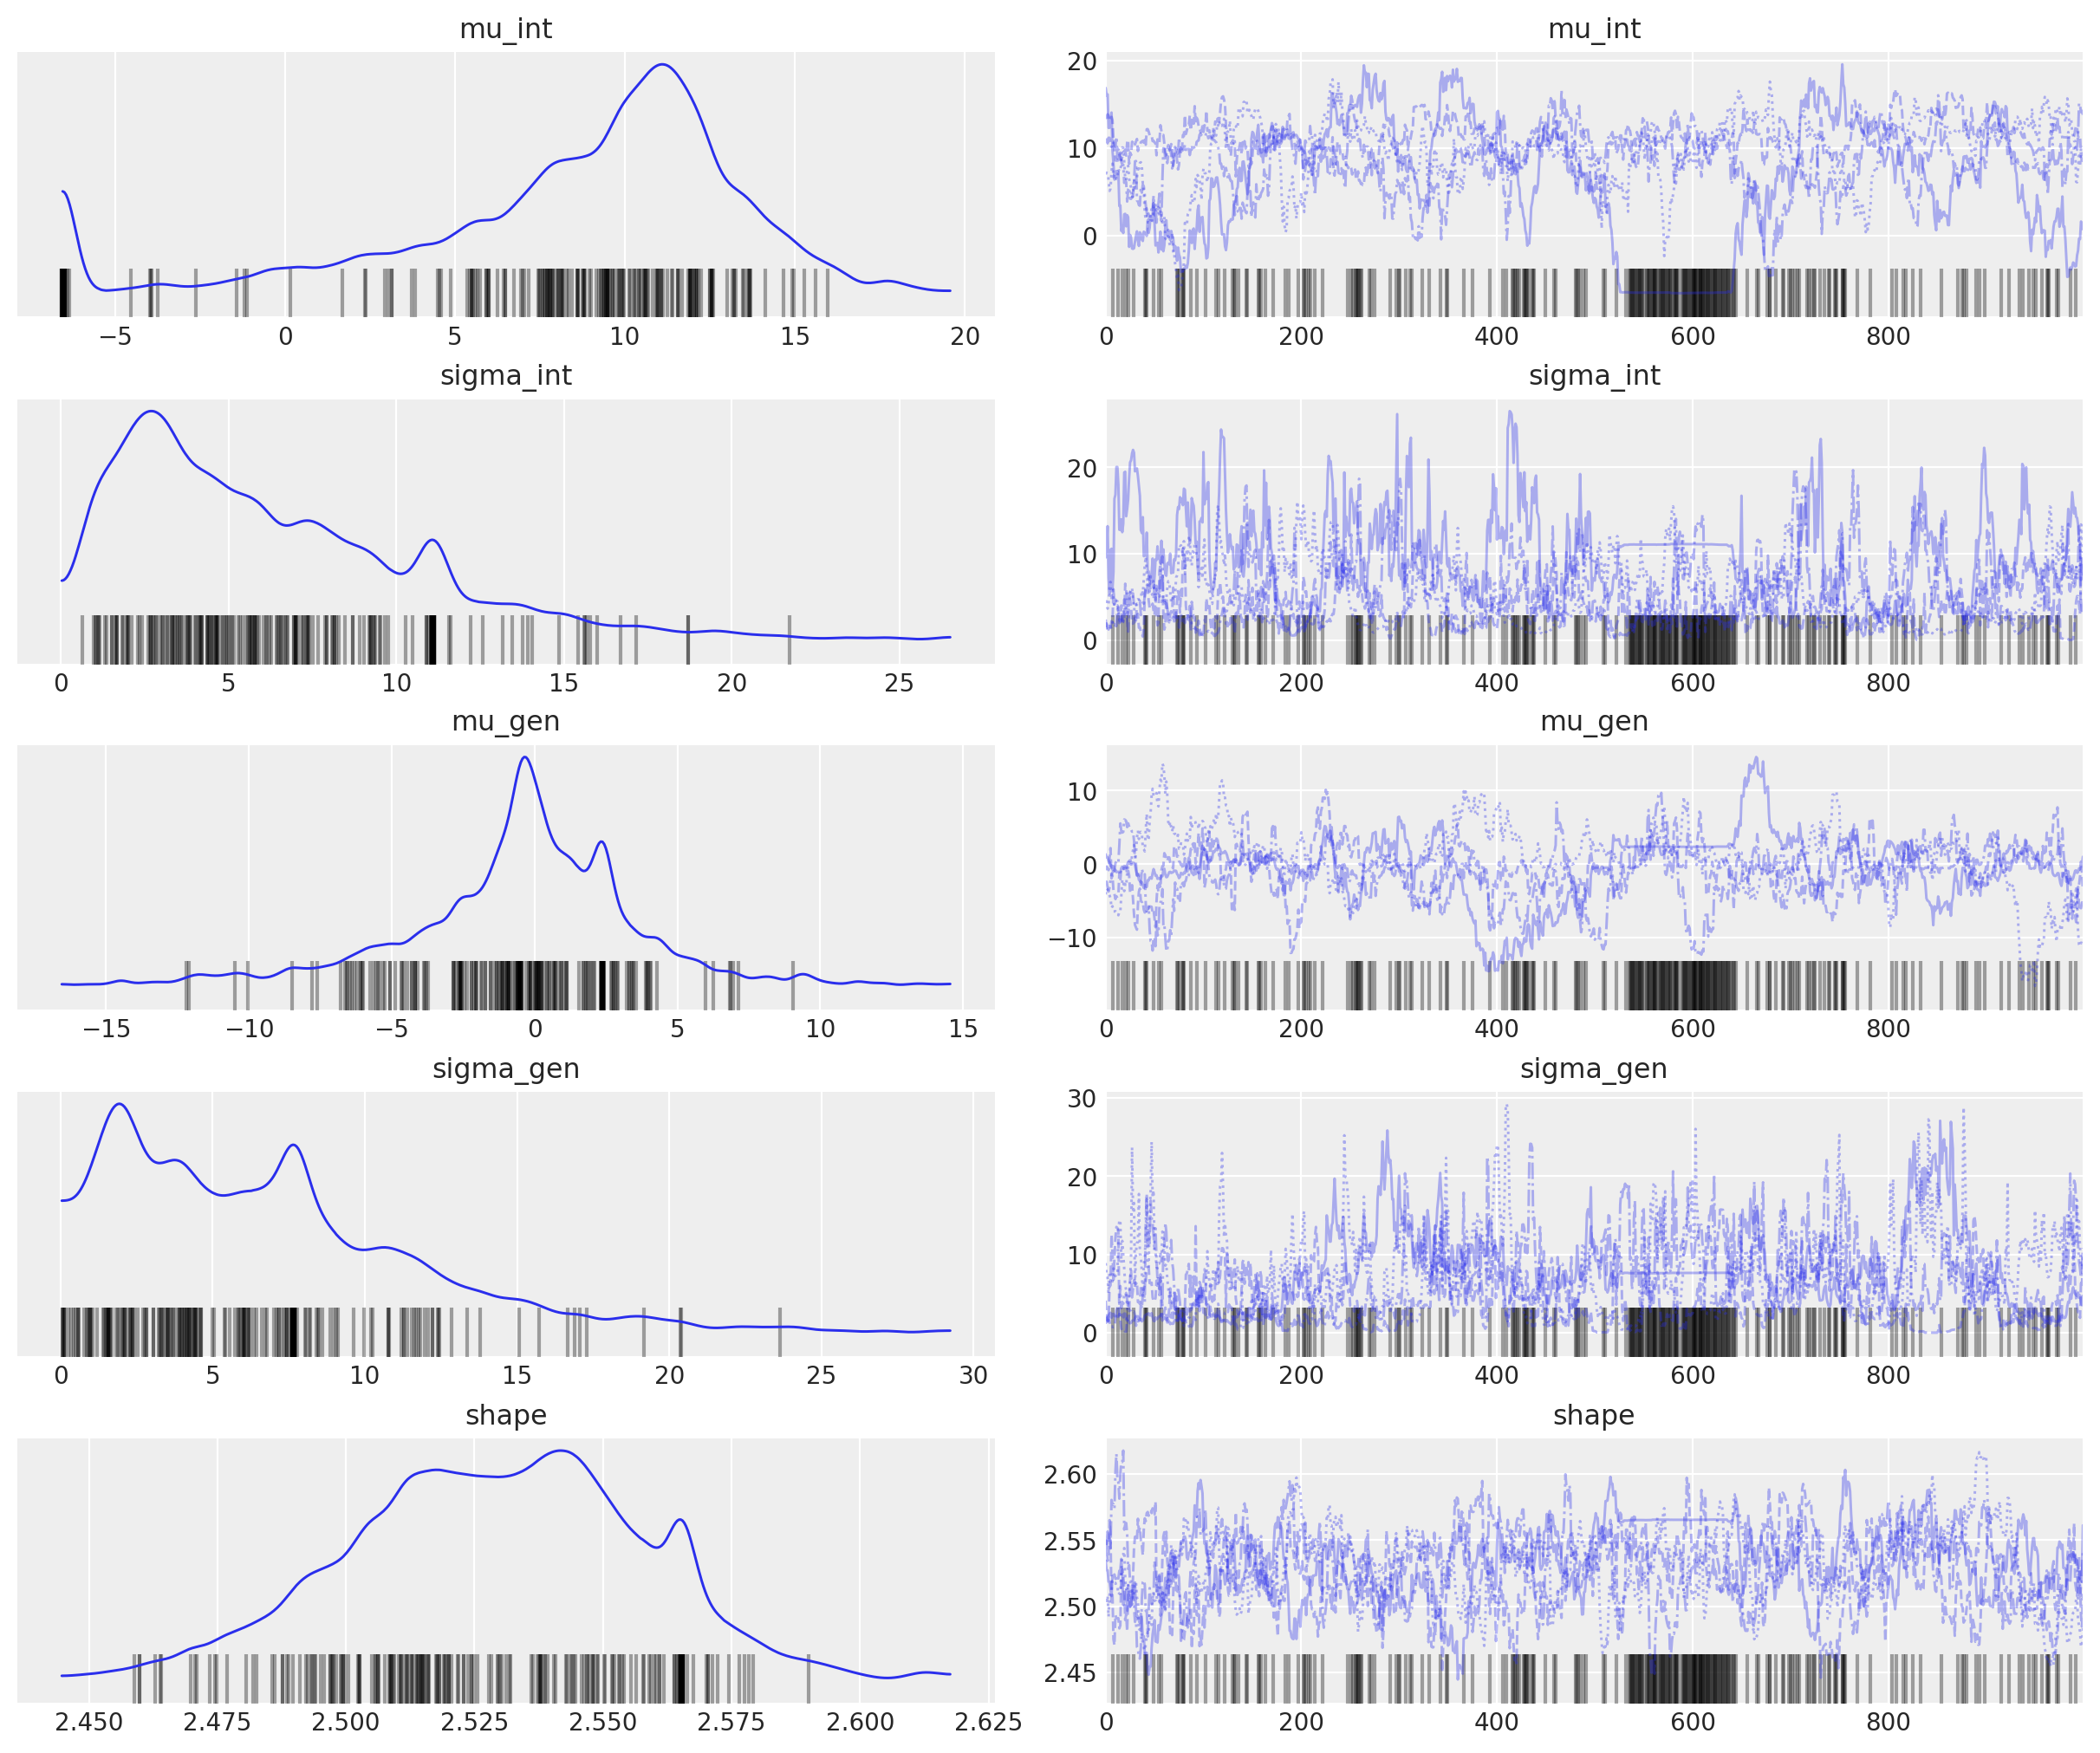

In [43]:
az.plot_trace(trace_fulldataset, var_names=["mu_int", "sigma_int", "mu_gen", "sigma_gen", "shape"], combined=True);

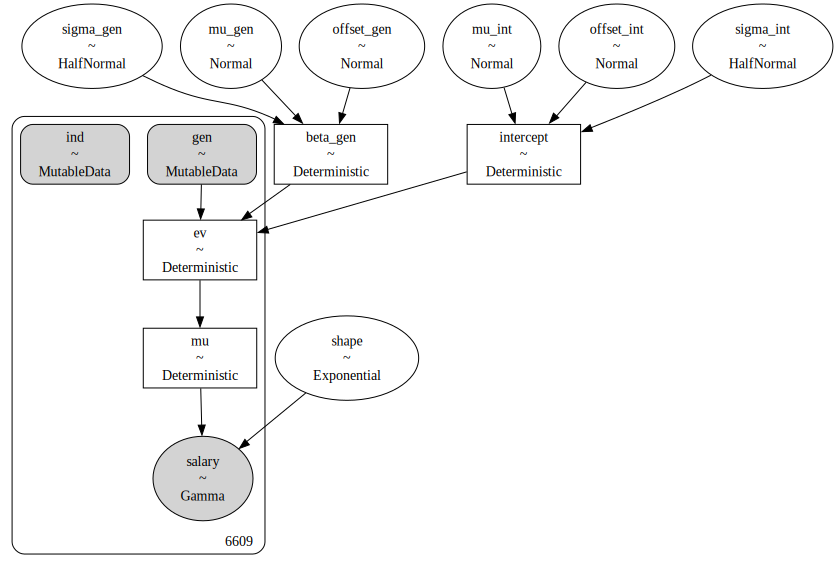

In [44]:
# Prepare data for 1997 model
ind_idx, industries = pd.factorize(df.query("year == 1997")["industry"])
sex_idx, sex = pd.factorize(df.query("year == 1997")["sex"])
salaries = df.query("year == 1997")["salary"].values

# Create coords
coords97 = {
    "obs": df.query("year == 1997").index,
    "ind": industries,
    "sex": sex
}

with pm.Model(coords=coords97) as model97:
    # Data
    ind = pm.MutableData("ind", ind_idx)
    gender = pm.MutableData("gen", sex_idx)

    # Hyperpriors
    mu_intercept = pm.Normal("mu_int", mu=0, sigma=10)
    sigma_intercept = pm.HalfNormal("sigma_int", sigma=10)
    mu_gender = pm.Normal("mu_gen", mu=0, sigma=10)
    sigma_gender = pm.HalfNormal("sigma_gen", sigma=10)

    # Priors
    offset_int = pm.Normal("offset_int", mu=0, sigma=1)
    intercept = pm.Deterministic("intercept", mu_intercept + offset_int * sigma_intercept)
    offset_gen = pm.Normal("offset_gen", mu=0, sigma=1)
    beta_gen = pm.Deterministic("beta_gen", mu_gender + offset_gen * sigma_gender)

    # Expected value
    ev = pm.Deterministic('ev', intercept + beta_gen * gender)
    mu = pm.Deterministic('mu',pm.math.exp(ev))

    # Model error
    shape = pm.Exponential("shape", lam=1)

    # Likelihood
    salary = pm.Gamma("salary", alpha=shape, beta=shape/mu, observed=salaries)   

pm.model_to_graphviz(model97)

In [45]:
with model97:
    trace97 = pmjax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:01.014097
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:04:04.693640
Transforming variables...
Transformation time =  0:00:00.605403


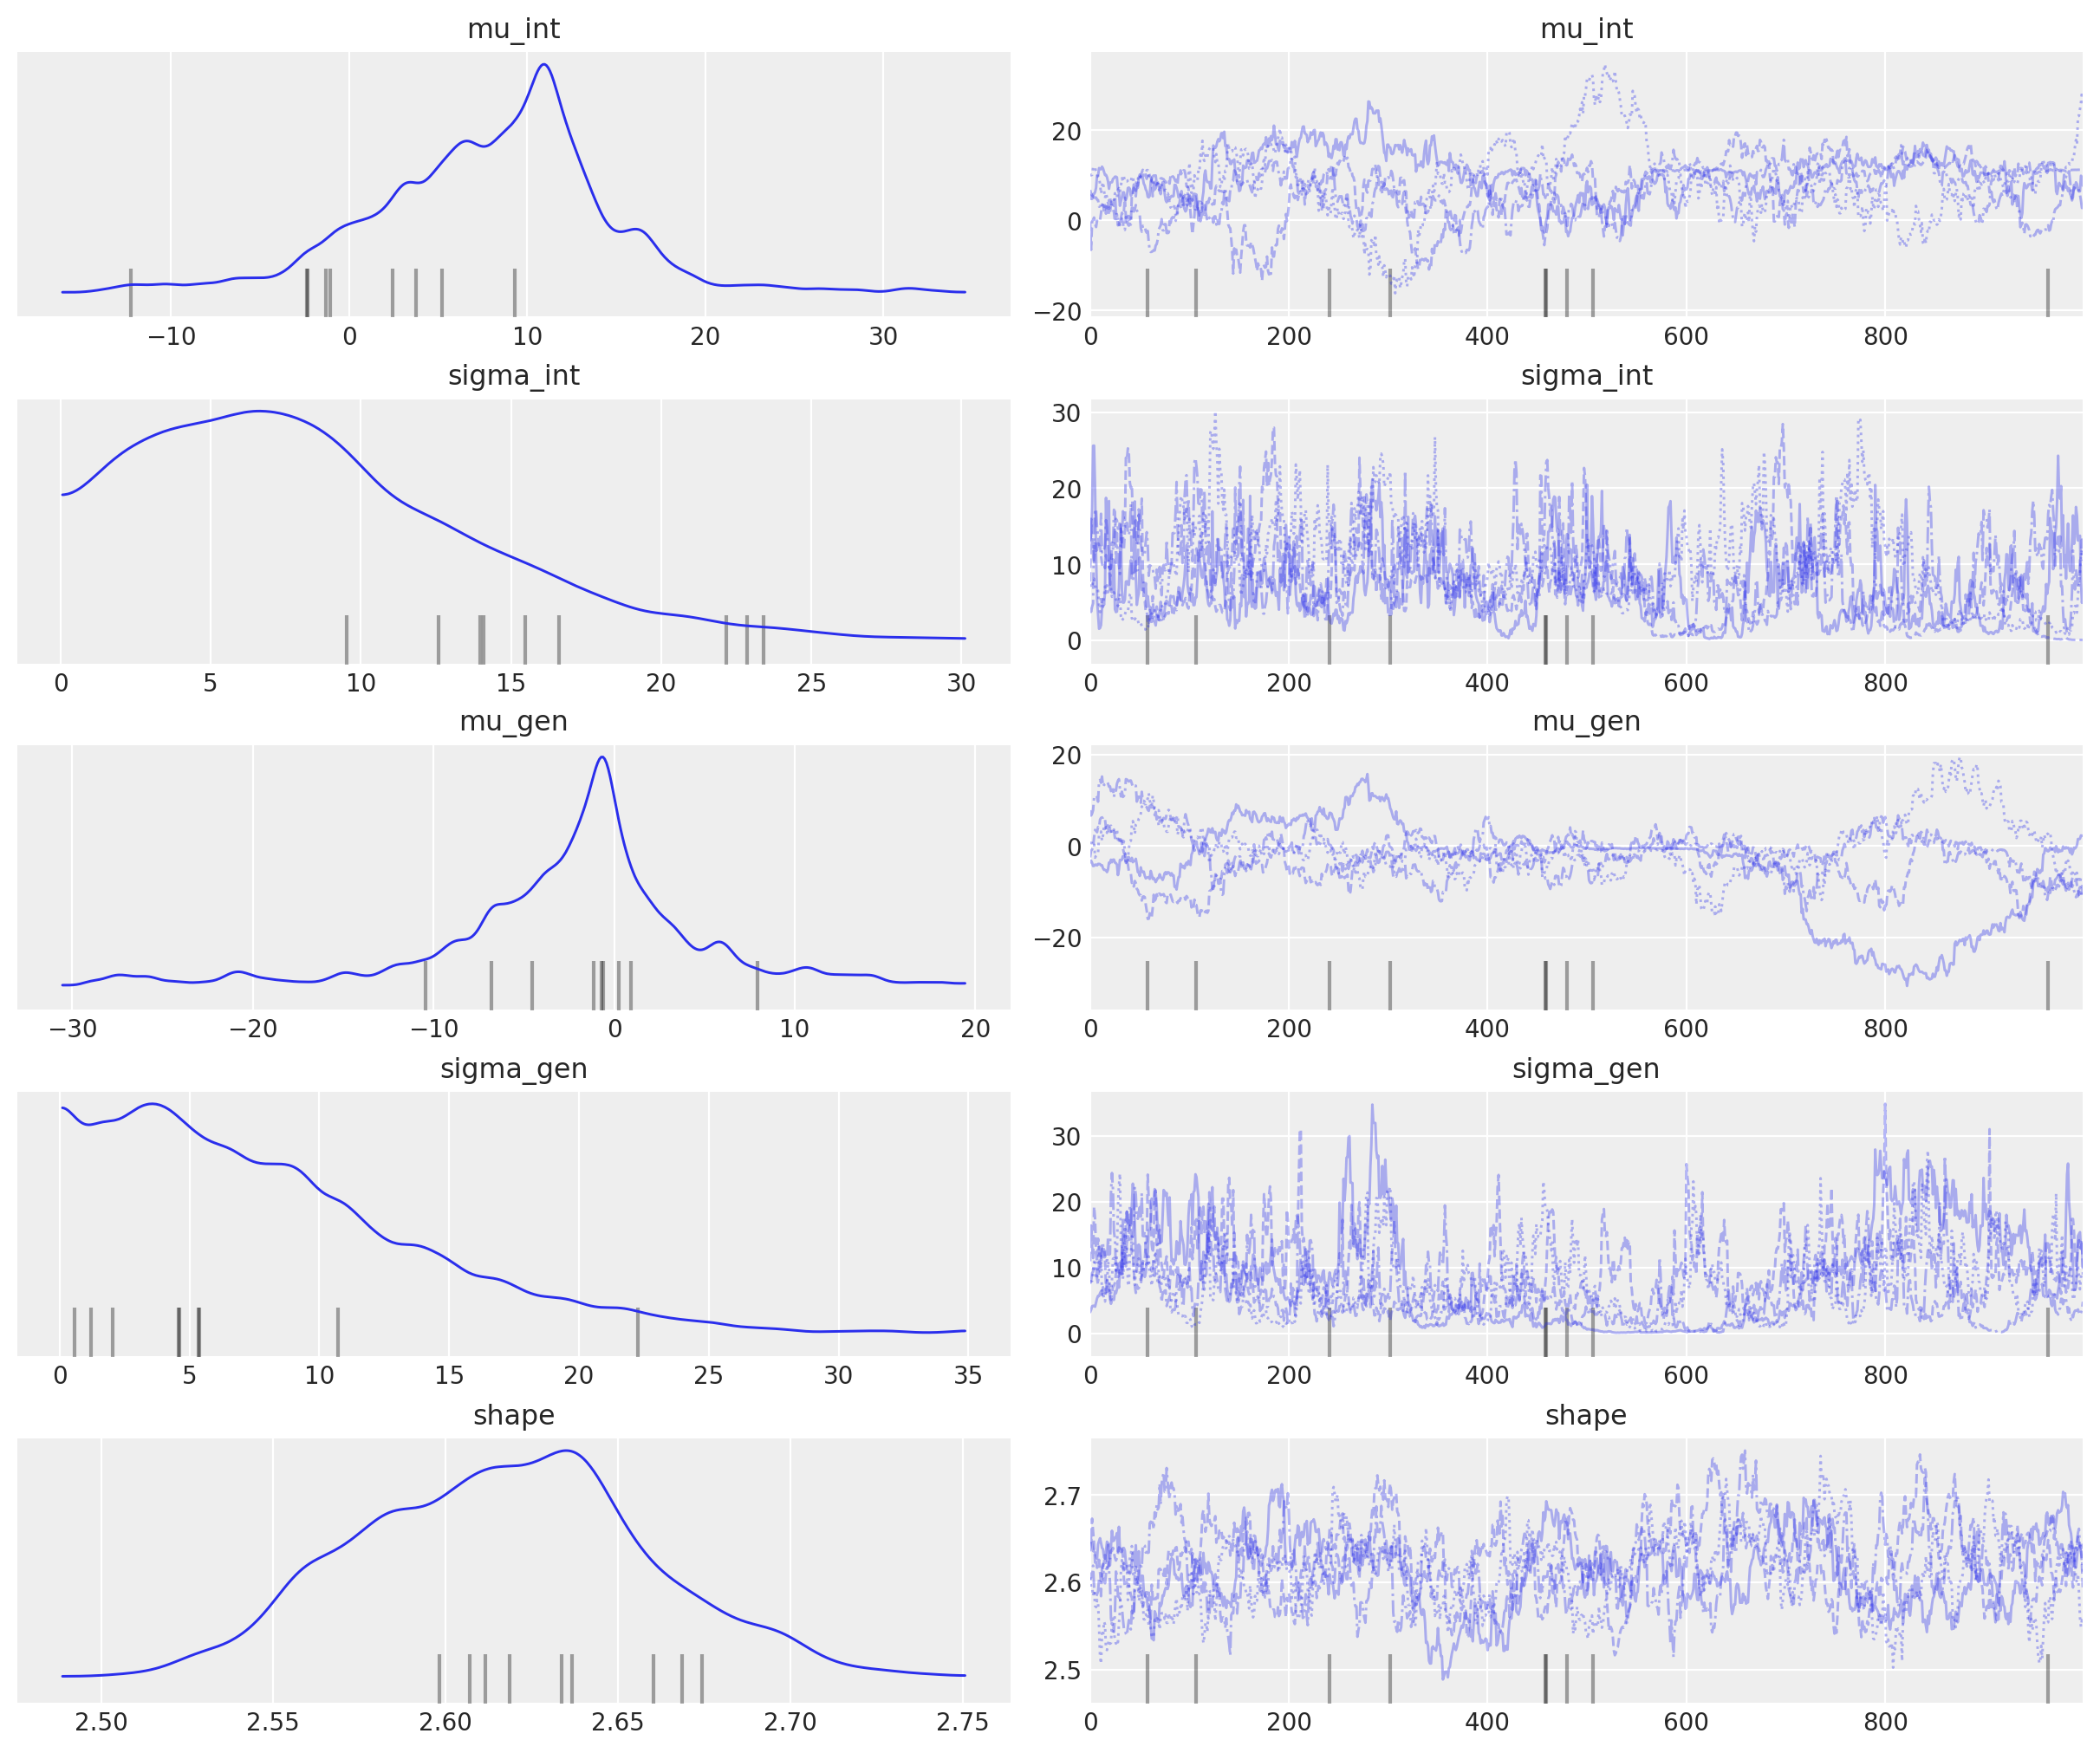

In [50]:
az.plot_trace(trace97, var_names=["mu_int", "sigma_int", "mu_gen", "sigma_gen", "shape"], combined=True);

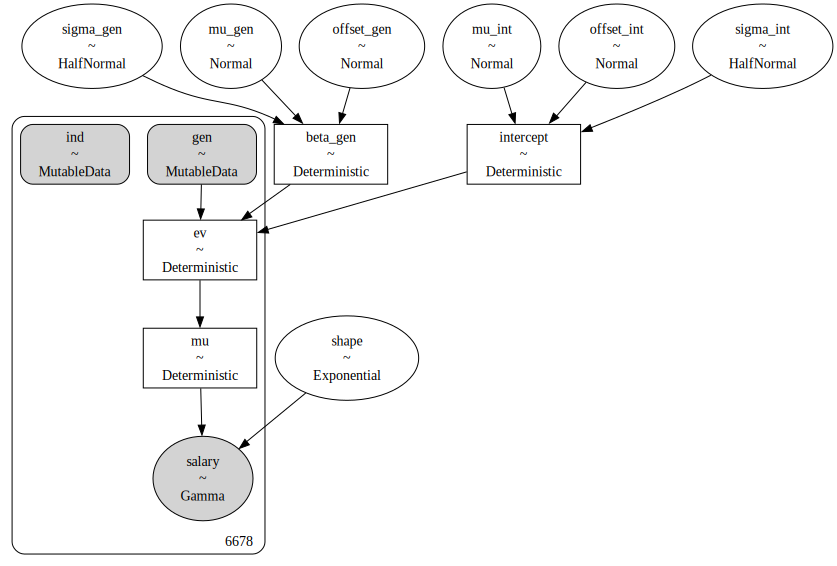

In [47]:
# Prepare data for 1998 model
ind_idx, industries = pd.factorize(df.query("year == 1998")["industry"])
sex_idx, sex = pd.factorize(df.query("year == 1998")["sex"])
salaries = df.query("year == 1998")["salary"].values

# Create coords
coords98 = {
    "obs": df.query("year == 1998").index,
    "ind": industries,
    "sex": sex
}

with pm.Model(coords=coords98) as model98:
    # Data
    ind = pm.MutableData("ind", ind_idx)
    gender = pm.MutableData("gen", sex_idx)

    # Hyperpriors
    mu_intercept = pm.Normal("mu_int", mu=0, sigma=10)
    sigma_intercept = pm.HalfNormal("sigma_int", sigma=10)
    mu_gender = pm.Normal("mu_gen", mu=0, sigma=10)
    sigma_gender = pm.HalfNormal("sigma_gen", sigma=10)

    # Priors
    offset_int = pm.Normal("offset_int", mu=0, sigma=1)
    intercept = pm.Deterministic("intercept", mu_intercept + offset_int * sigma_intercept)
    offset_gen = pm.Normal("offset_gen", mu=0, sigma=1)
    beta_gen = pm.Deterministic("beta_gen", mu_gender + offset_gen * sigma_gender)

    # Expected value
    ev = pm.Deterministic('ev', intercept + beta_gen * gender)
    mu = pm.Deterministic('mu',pm.math.exp(ev))

    # Model error
    shape = pm.Exponential("shape", lam=1)

    # Likelihood
    salary = pm.Gamma("salary", alpha=shape, beta=shape/mu, observed=salaries)   

pm.model_to_graphviz(model98)

In [48]:
with model98:
    trace98 = pmjax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:01.450870
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:04:15.416710
Transforming variables...
Transformation time =  0:00:00.624625


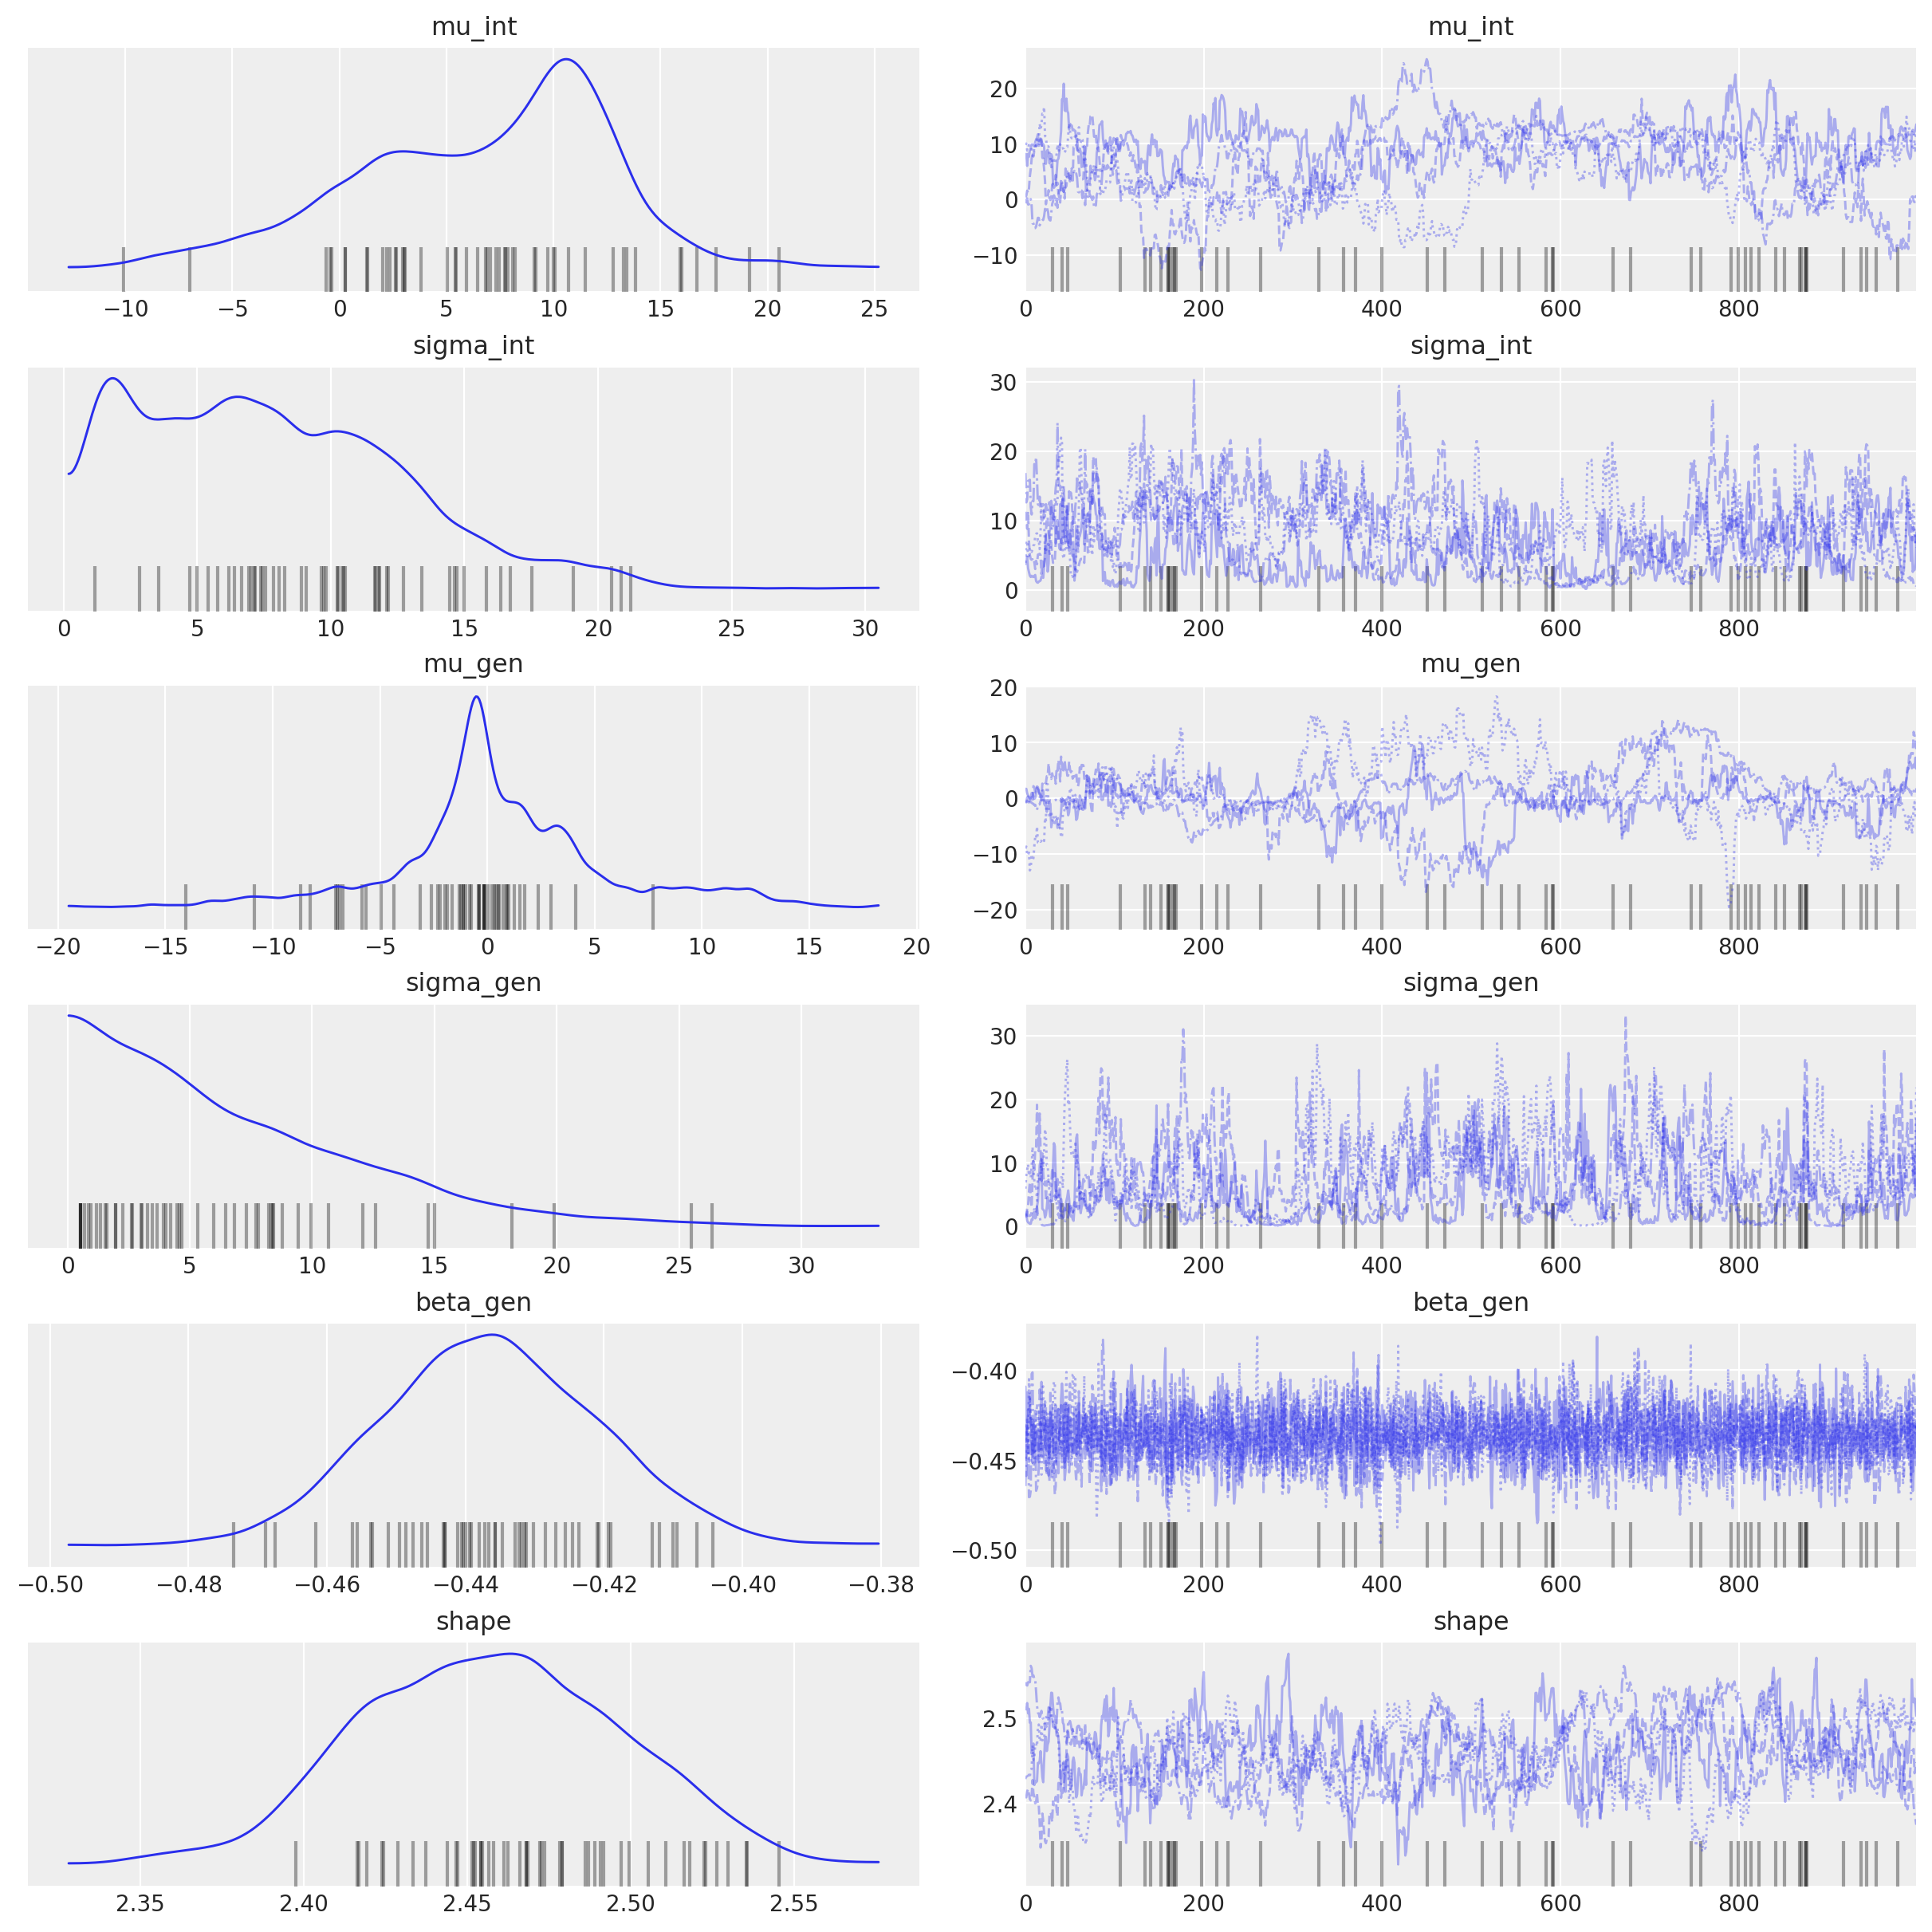

In [49]:
az.plot_trace(trace98, var_names=["mu_int", "sigma_int", "mu_gen", "sigma_gen","beta_gen", "shape"], combined=True);

## Simulation

In [128]:
# True parameters
a = 1000
b = 500
n = 20000

# Simulate data
index = np.arange(n)
union = np.random.binomial(1, 0.5, size=n)
salary = a + b * union + np.random.normal(0, 100, size=n)

uni_idx, unions = pd.factorize(union)

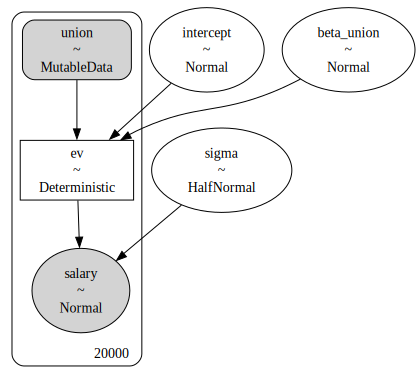

In [129]:
with pm.Model() as test:
    # Data
    data_union = pm.MutableData("union", uni_idx)
    # Priors
    intercept = pm.Normal("intercept", mu=1000, sigma=200)
    beta_union = pm.Normal("beta_union", mu=1000, sigma=10)
    # Expected value
    mu = pm.Deterministic('ev', intercept + beta_union * data_union)

    # Model error
    sigma = pm.HalfNormal("sigma", sigma=10)
    # Likelihood
    y = pm.Normal("salary", mu=mu, sigma=sigma, observed=salary)

pm.model_to_graphviz(test)

In [130]:
with test:
    trace = pmjax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:00.786345
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.517077
Transforming variables...
Transformation time =  0:00:00.215246


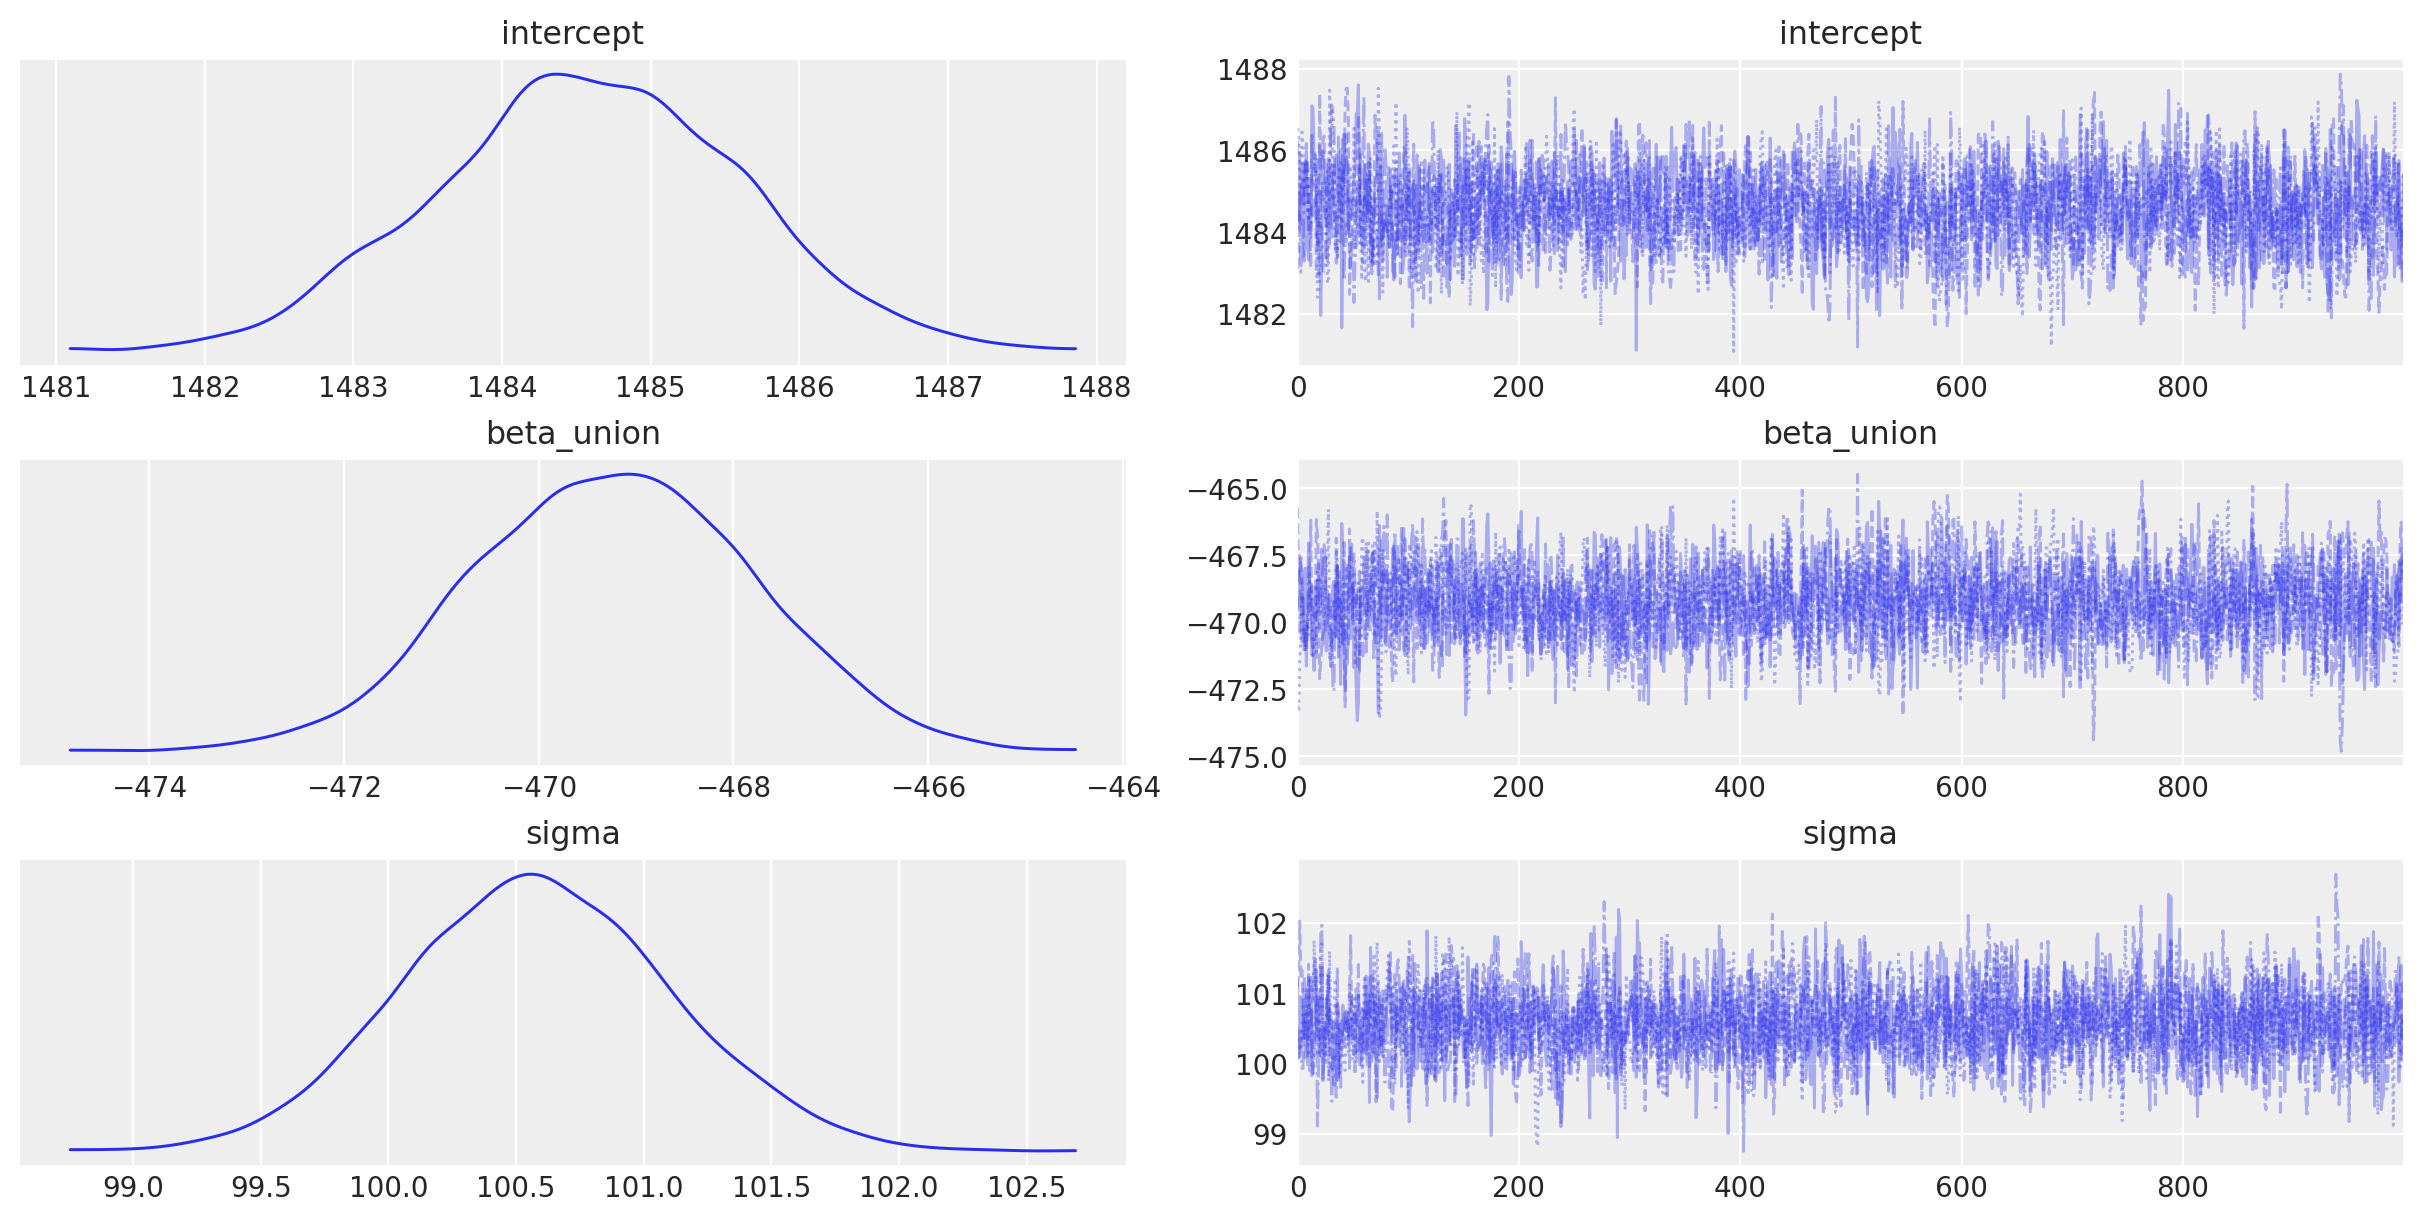

In [131]:
az.plot_trace(trace, var_names=["intercept", "beta_union", "sigma"], combined=True);

## Update

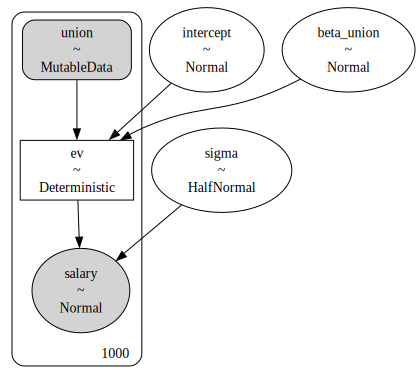

In [140]:
uni_idx, unions = pd.factorize(union[:1000])
salaries = salary[:1000]

with pm.Model() as test2:
    # Data
    data_union = pm.MutableData("union", uni_idx)
    # Priors
    intercept = pm.Normal("intercept", mu=1000, sigma=10)
    beta_union = pm.Normal("beta_union", mu=1000, sigma=10)
    # Expected value
    mu = pm.Deterministic('ev', intercept + beta_union * data_union)

    # Model error
    sigma = pm.HalfNormal("sigma", sigma=10)
    # Likelihood
    y = pm.Normal("salary", mu=mu, sigma=sigma, observed=salaries)

pm.model_to_graphviz(test2)

In [141]:
with test2:
    trace2 = pmjax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:00.761590
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:02.736748
Transforming variables...
Transformation time =  0:00:00.030731


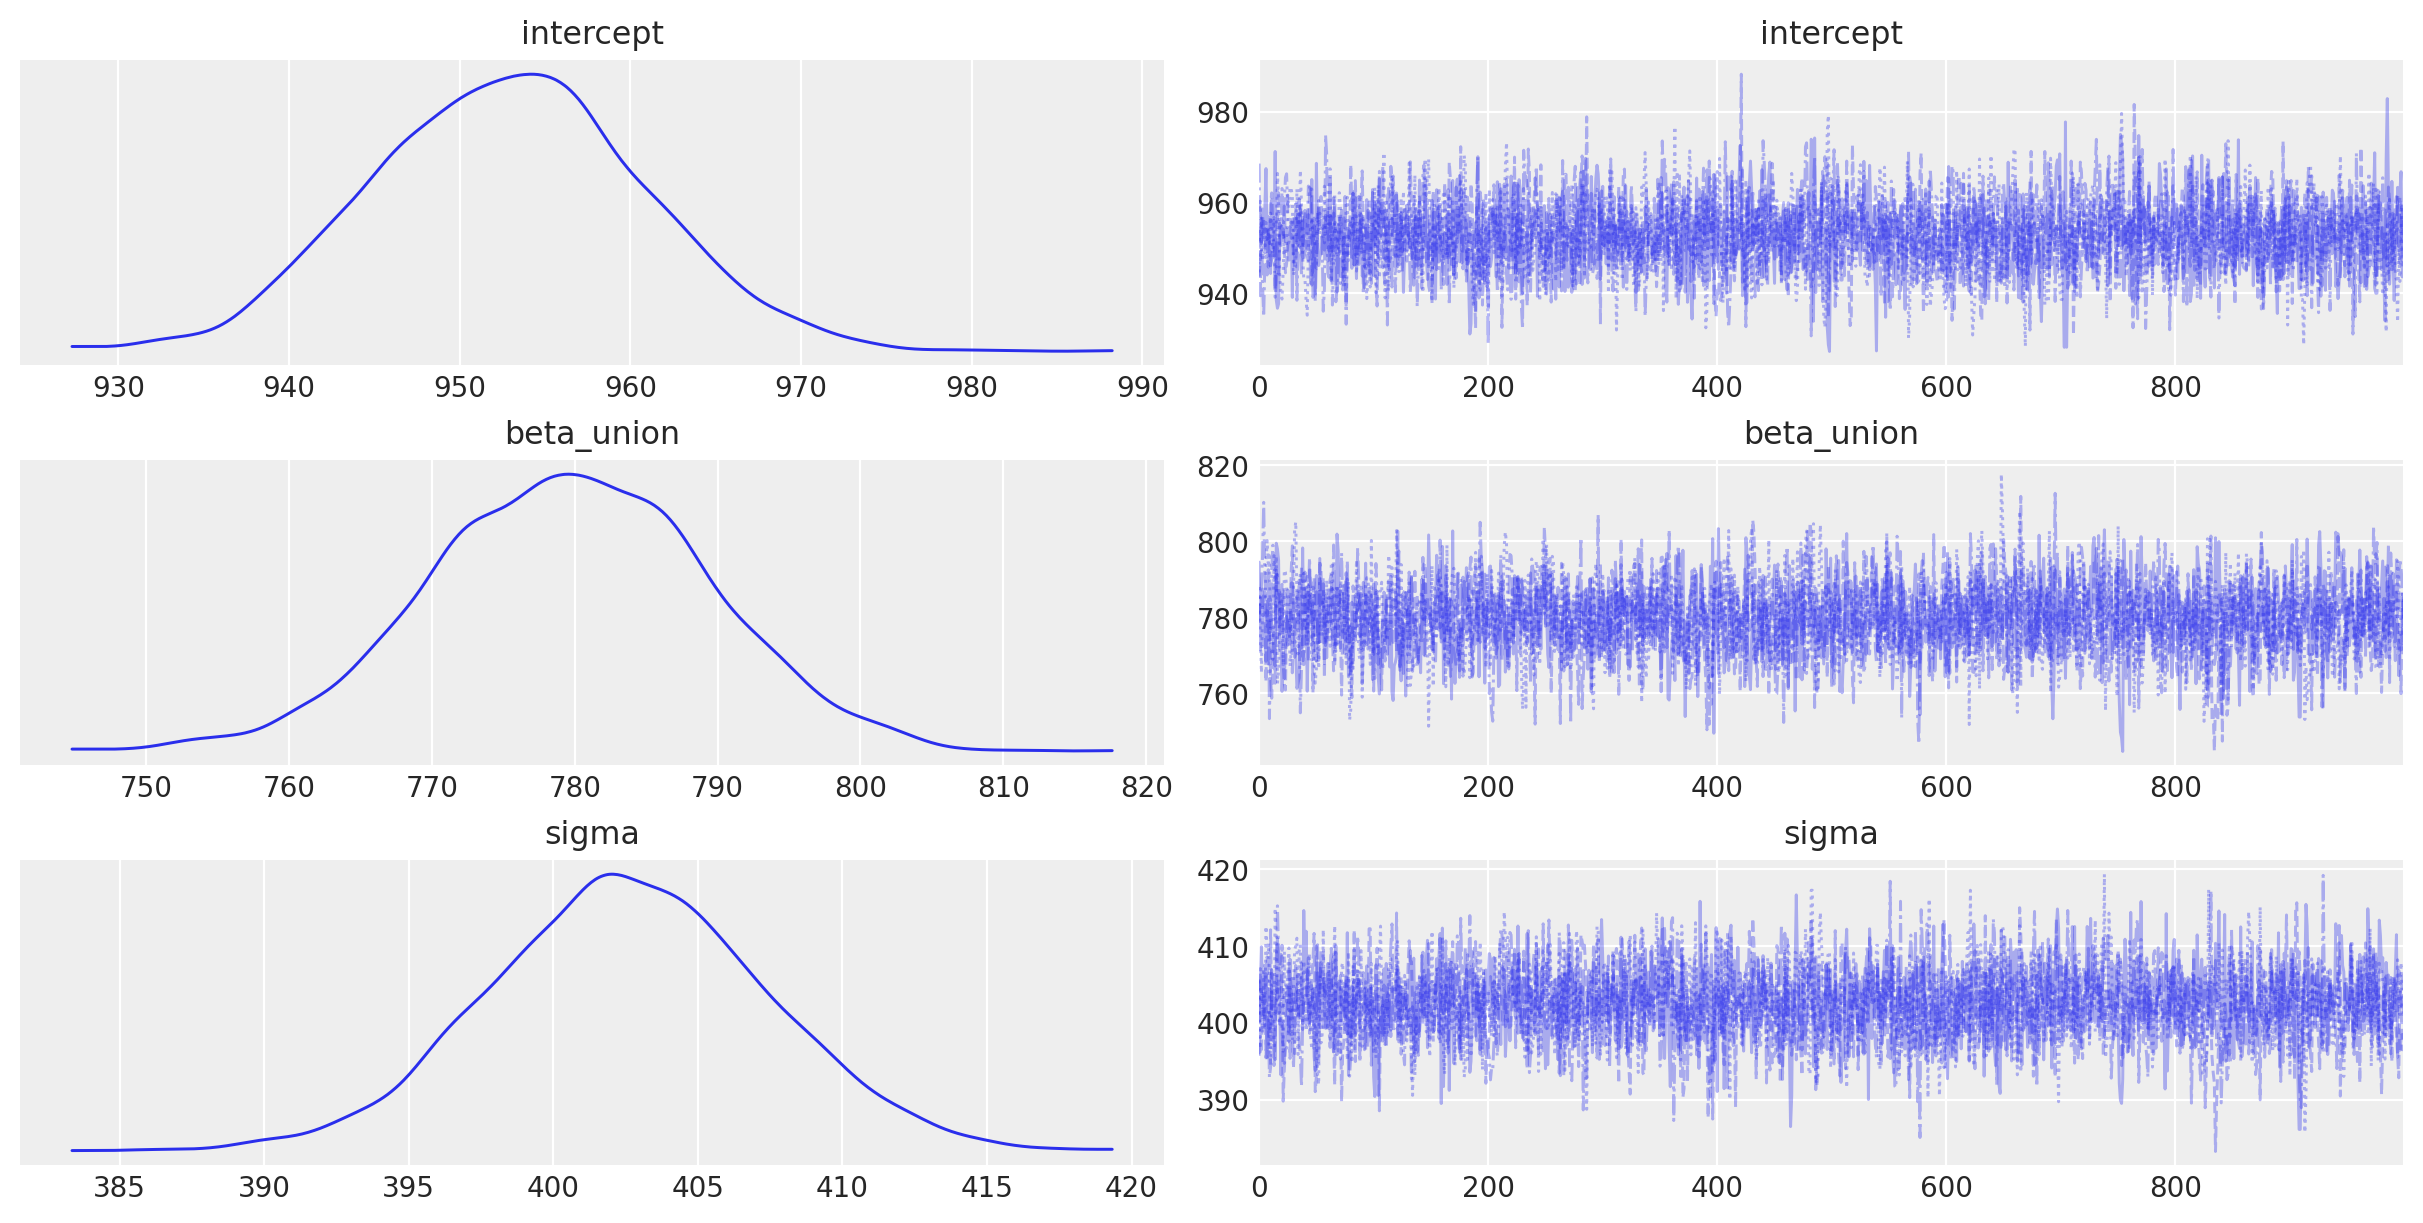

In [142]:
az.plot_trace(trace2, var_names=["intercept", "beta_union", "sigma"], combined=True);

In [143]:
from scipy.stats import gaussian_kde

def prior_update(parameter, trace):
        mean = trace.posterior[parameter].values.mean()
        std = trace.posterior[parameter].values.std()

        return mean, std

In [144]:
for data_slice in range(2000, 11000, 1000):
    uni_idx, unions = pd.factorize(union[data_slice:data_slice+1000])
    salaries = salary[data_slice:data_slice+1000]

    print(f"Data slice: {data_slice}")

    if data_slice == 2000:
        trace = trace2
    else:
        trace = trace3

    with pm.Model() as test3:
        # Data
        data_union = pm.MutableData("union", uni_idx)
        # Priors
        mu_intercept, sigma_intercept = prior_update("intercept", trace)
        mu_beta_union, sigma_beta_union = prior_update("beta_union", trace)
        sig_prior = prior_update("sigma", trace)
        print(f"--->mu_intercept: {mu_intercept}, sigma_intercept: {sigma_intercept}")
        print(f"--->mu_beta_union: {mu_beta_union}, sigma_beta_union: {sigma_beta_union}")
        print(f"--->sigma: {sig_prior}")

        intercept = pm.Normal("intercept", mu=mu_intercept, sigma=sigma_intercept)
        beta_union = pm.Normal("beta_union", mu=mu_beta_union, sigma=sigma_beta_union)

        # Expected value
        mu = pm.Deterministic('ev', intercept + beta_union * data_union)

        # Model error
        sigma = pm.HalfNormal("sigma", sigma=sig_prior[0])
        # Likelihood
        y = pm.Normal("salary", mu=mu, sigma=sigma, observed=salaries)

        trace3 = pm.sample()

    pm.model_to_graphviz(test3)

Data slice: 2000
--->mu_intercept: 952.8226927142651, sigma_intercept: 7.970922826239315
--->mu_beta_union: 779.5962473707049, sigma_beta_union: 9.756582370758965
--->sigma: (402.56205094684316, 4.8294457871600835)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_union, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Data slice: 3000
--->mu_intercept: 957.5848505637185, sigma_intercept: 3.9898559326141685
--->mu_beta_union: 594.6114687377841, sigma_beta_union: 6.1575600196986455
--->sigma: (106.72463653453343, 2.759232879939101)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_union, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Data slice: 4000
--->mu_intercept: 958.8042722912556, sigma_intercept: 3.855519740068196
--->mu_beta_union: 560.4448922479721, sigma_beta_union: 6.021894847625994
--->sigma: (530.6314479380587, 11.808367425316296)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_union, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Data slice: 5000
--->mu_intercept: 959.7154474472574, sigma_intercept: 3.747080535794477
--->mu_beta_union: 527.6375256145787, sigma_beta_union: 6.066411061739597
--->sigma: (521.4117159520421, 12.030747816185638)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_union, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Data slice: 6000
--->mu_intercept: 961.9372500040184, sigma_intercept: 3.7134810386620347
--->mu_beta_union: 495.31890972181515, sigma_beta_union: 6.128333832039554
--->sigma: (507.39035299639653, 11.398615671381016)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_union, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Data slice: 7000
--->mu_intercept: 966.3208991136011, sigma_intercept: 3.6226148533282223
--->mu_beta_union: 464.999940035537, sigma_beta_union: 6.075029653957649
--->sigma: (501.20043155791876, 11.197232394855185)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_union, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Data slice: 8000
--->mu_intercept: 969.7220482438869, sigma_intercept: 3.4992538165189053
--->mu_beta_union: 432.51741042679816, sigma_beta_union: 6.108405359684313
--->sigma: (478.9659955029362, 11.051766891454673)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_union, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Data slice: 9000
--->mu_intercept: 974.0787506487649, sigma_intercept: 3.4230348063269838
--->mu_beta_union: 400.44717101597087, sigma_beta_union: 5.9609654273846555
--->sigma: (463.01365798721395, 10.612818795577356)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_union, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Data slice: 10000
--->mu_intercept: 978.7720607610994, sigma_intercept: 3.3573743681387875
--->mu_beta_union: 370.37685632929157, sigma_beta_union: 5.7433401900929075
--->sigma: (458.19521028700353, 10.34246812449206)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_union, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


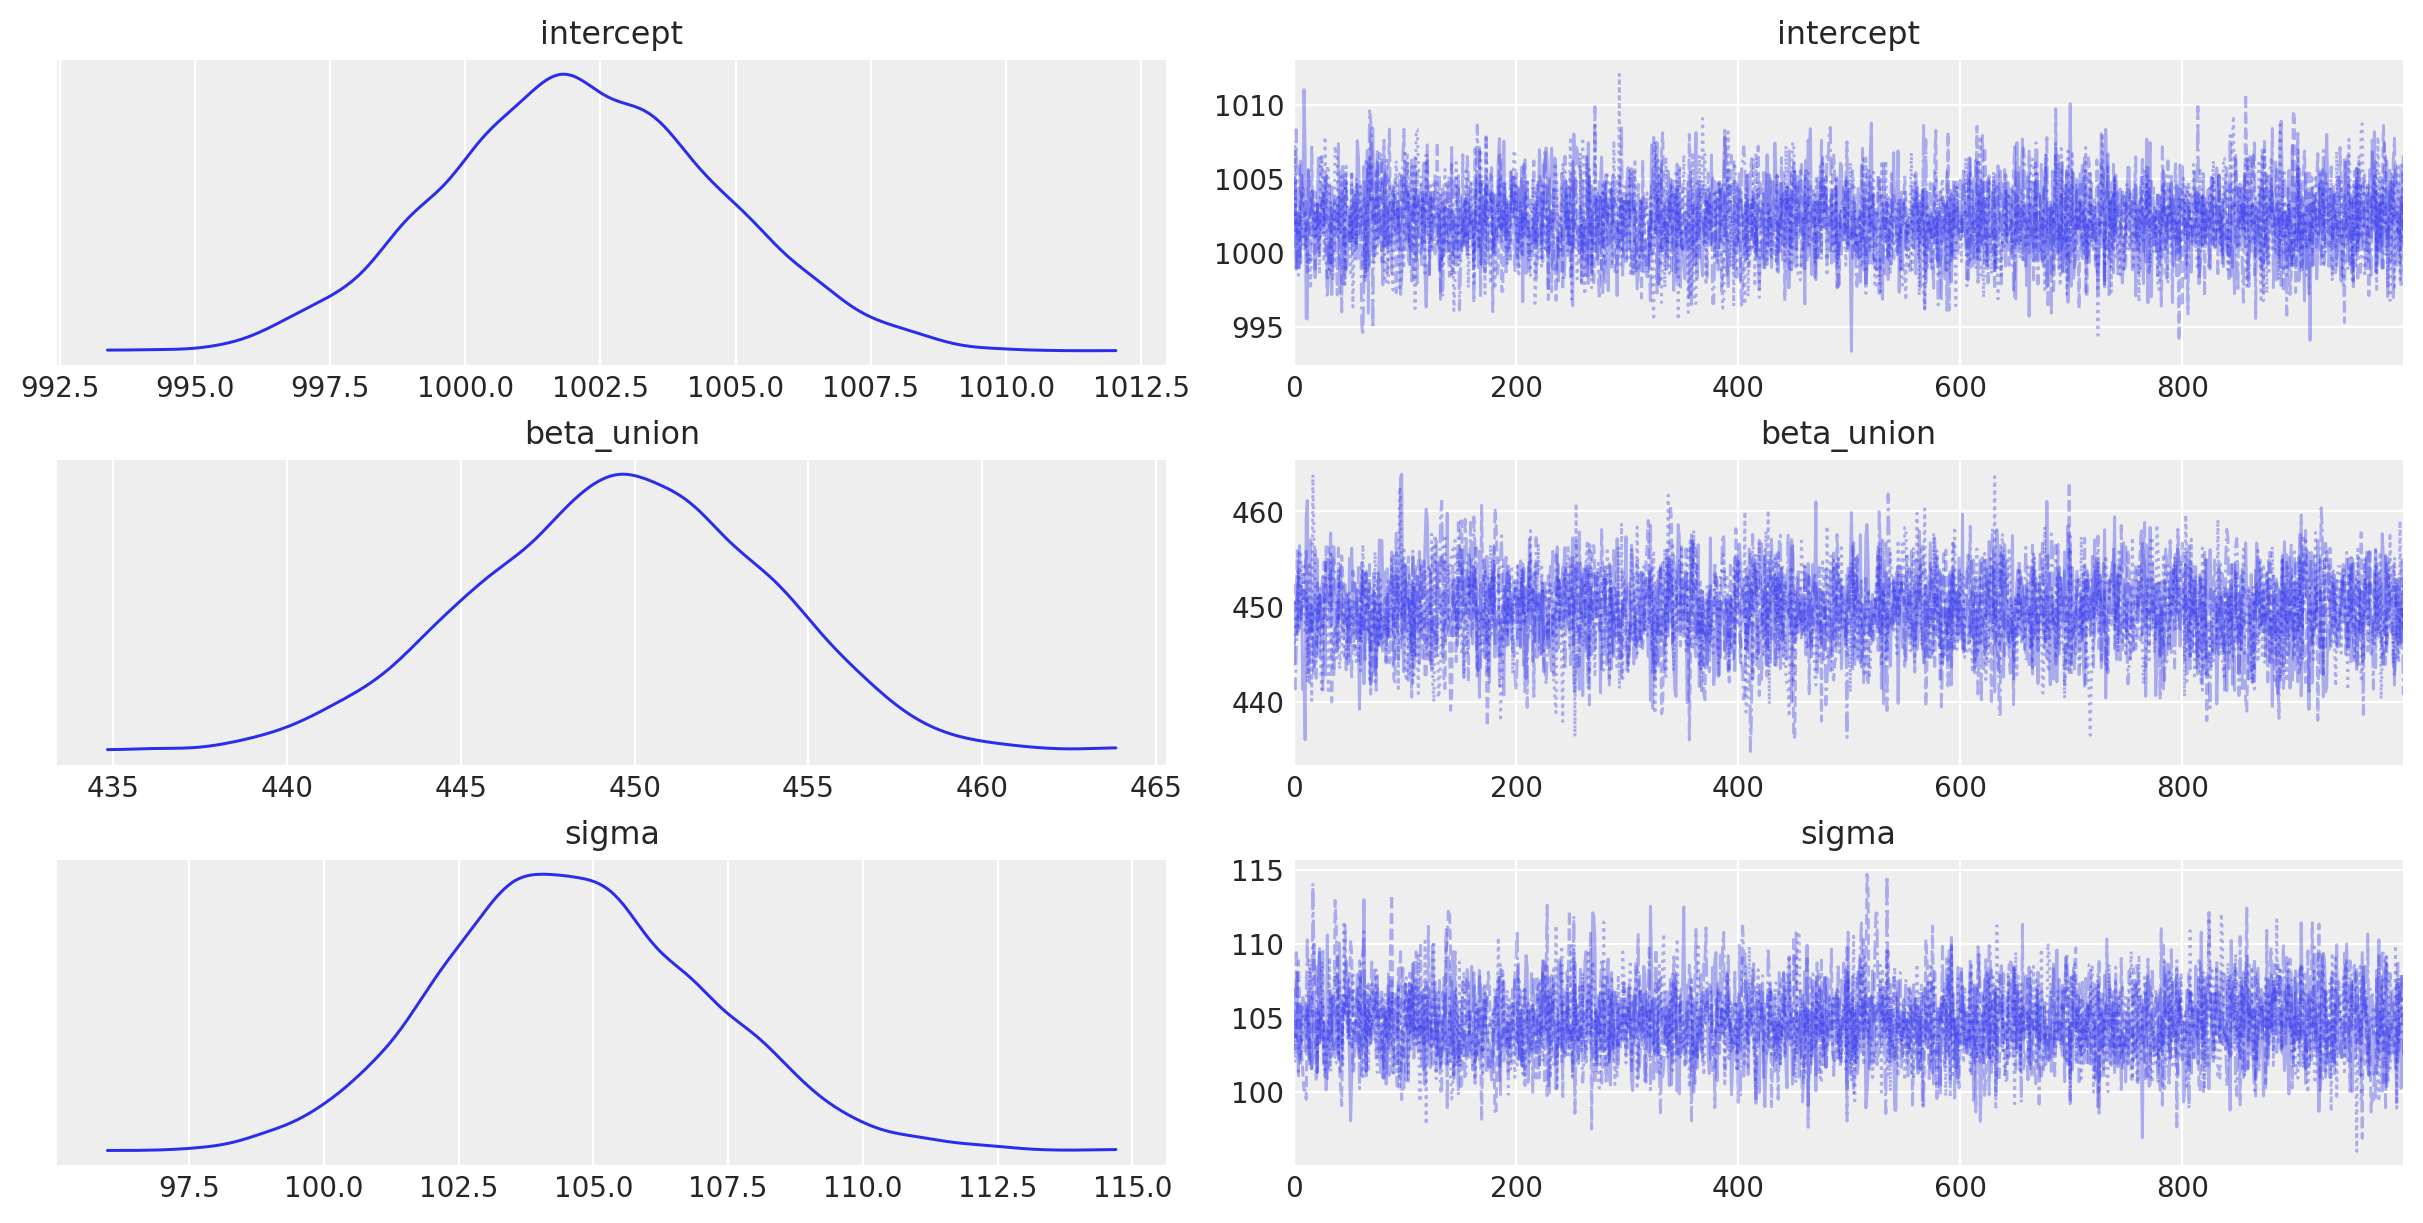

In [145]:
az.plot_trace(trace3, var_names=["intercept", "beta_union", "sigma"], combined=True);

In [147]:
pm.summary(trace3, var_names=["intercept", "beta_union", "sigma"])

mean     sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept   1002.164  2.557  997.171  1006.758      0.040    0.028    4091.0   
beta_union   449.569  4.206  441.756   457.263      0.078    0.055    2888.0   
sigma        104.660  2.509   99.917   109.246      0.043    0.030    3515.0   

            ess_tail  r_hat  
intercept     3082.0    1.0  
beta_union    3283.0    1.0  
sigma         2950.0    1.0

In [92]:
with test3:
    

SyntaxError: incomplete input (1168544615.py, line 2)

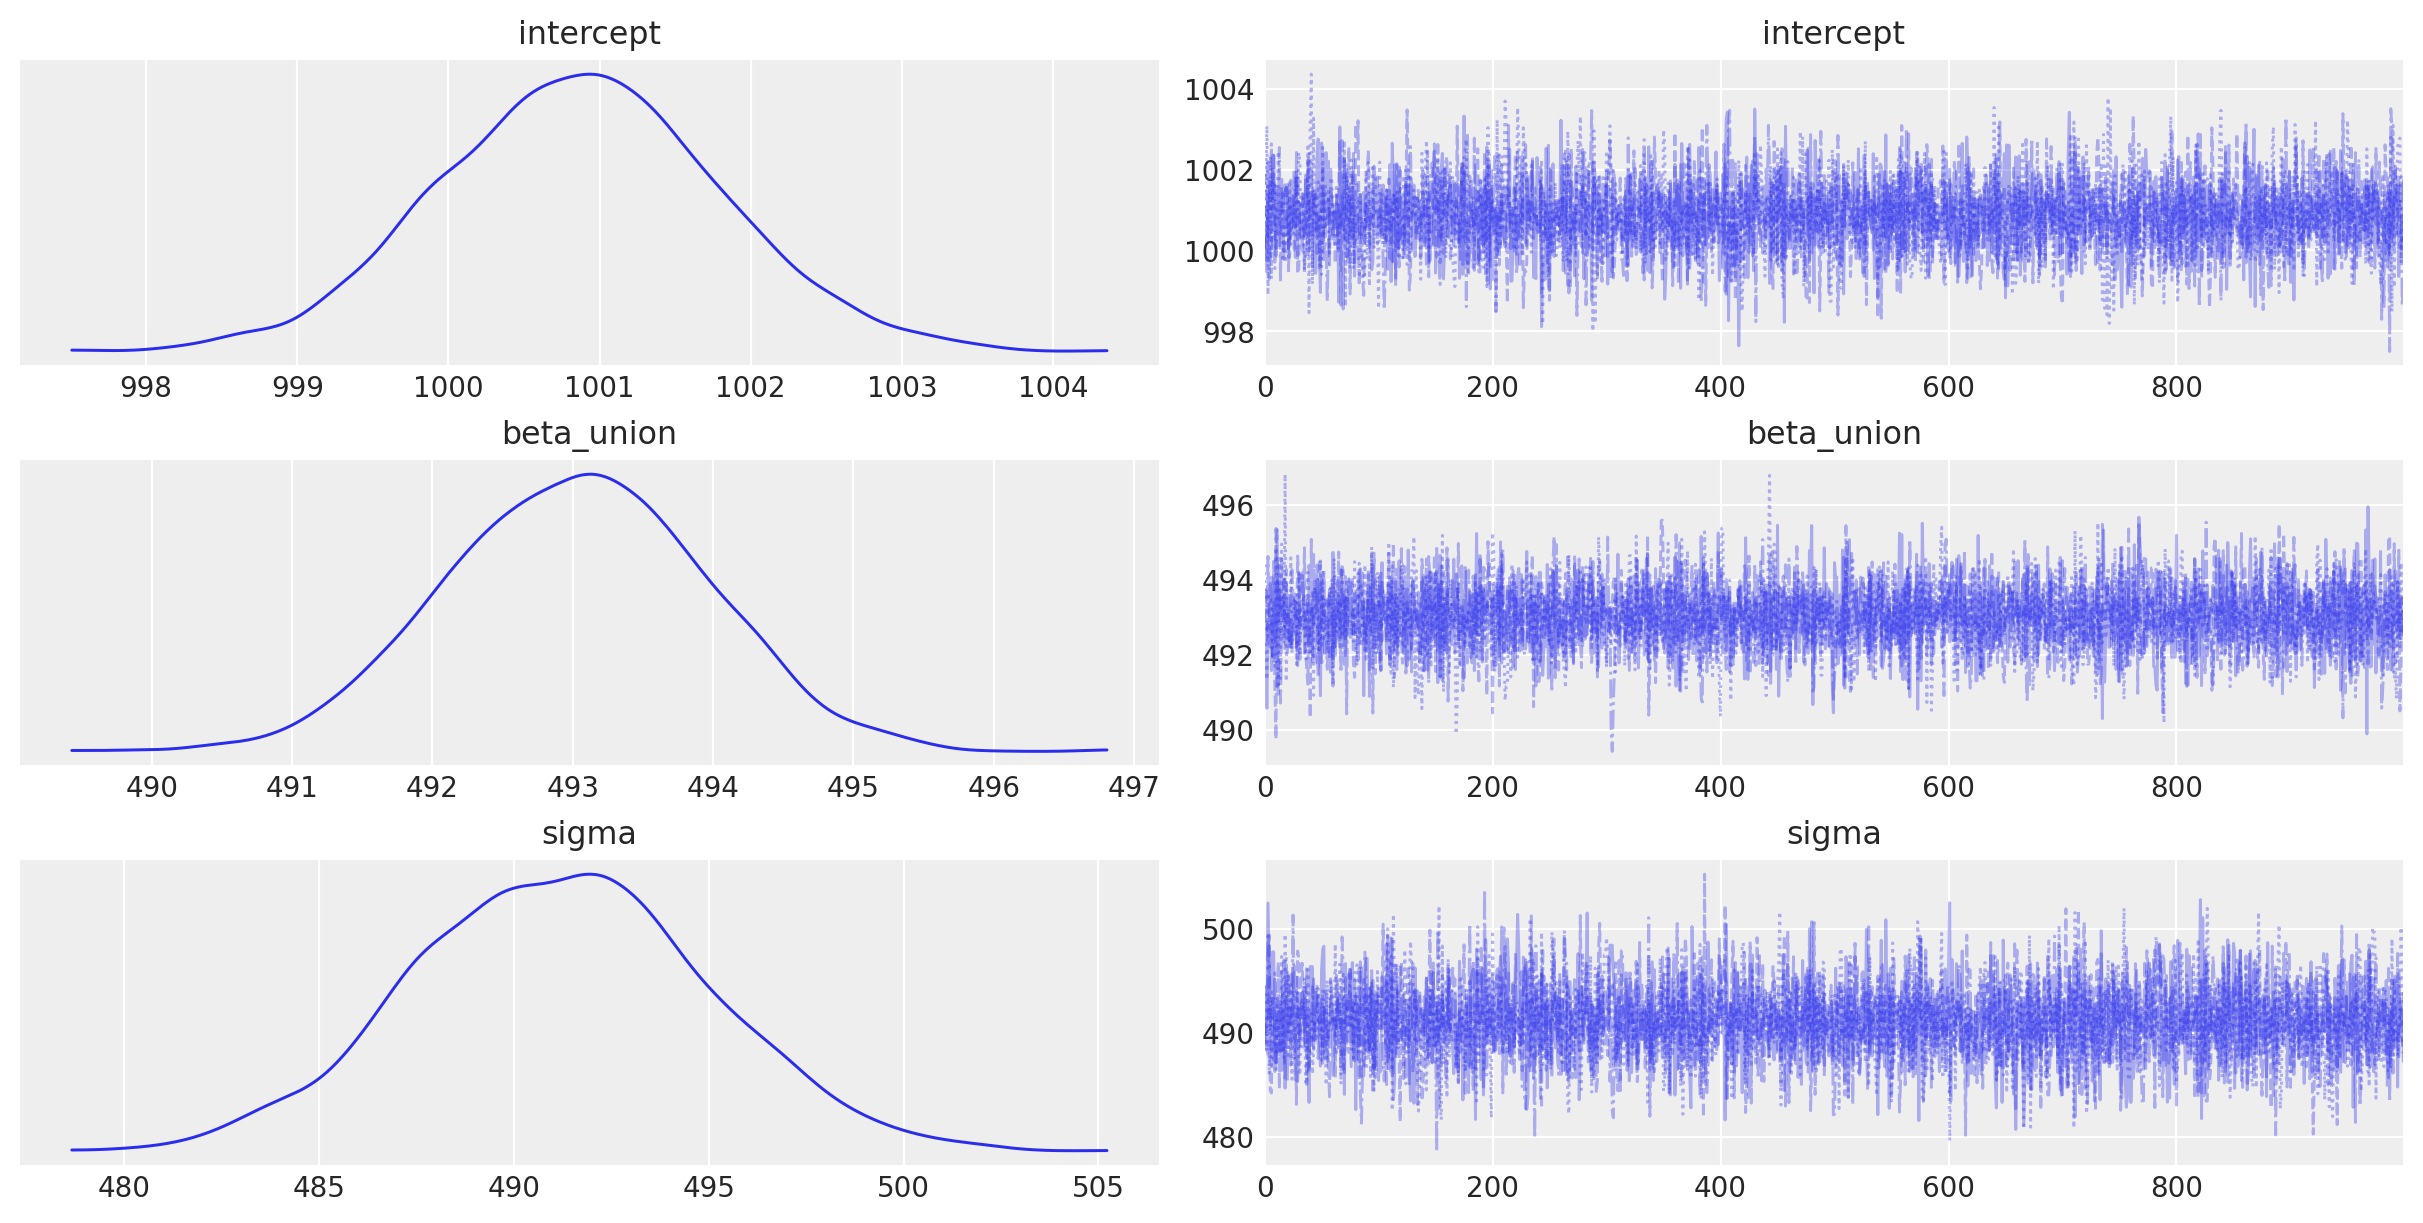

In [74]:
az.plot_trace(trace3, var_names=["intercept", "beta_union", "sigma"], combined=True);